In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
from pandas_datareader import data as pd_data
import statsmodels.tsa.api as tsa
import laplacejumps as lj

In [2]:
presentation = False

In [3]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')

if presentation:
    fontsize=22
else:
    fontsize = 16
mpl.rc('legend', **{'fontsize':fontsize})
mpl.rc('axes', **{'labelsize':fontsize, 'titlesize':fontsize})
mpl.rc('xtick', **{'labelsize':fontsize})
mpl.rc('ytick', **{'labelsize': fontsize})

## Load Data

In [4]:
with pd.HDFStore('../results/spy_daily_estimates_2003-2017_1000_1sec.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est'].loc[:, ['diffusion', 'jumps']]
    bipower_vol = volatility_store['bipower_vol']
    daily_rtn = volatility_store['daily_rtn'].loc[discrete_vol.index]
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
discrete_vol['jump_prop'] = discrete_vol['jumps'] / discrete_vol['quad']
log_vol = discrete_vol.transform(np.log).dropna()

In [5]:
with pd.HDFStore('../results/spy_5min_estimates_2003-2017.hdf') as volatility_store:
    discrete_vol['real_vol'] = volatility_store['real_vol']

In [6]:
nber_recessions = pd_data.DataReader('USREC', 'fred', start='1950', end='2017')
vix = pd_data.DataReader('VIXCLS', 'fred', start='1990', end='2017').rename(columns={'VIXCLS':'vix'})

In [7]:
discrete_vol.head()

diffusion       jumps        quad  jump_prop    real_vol
0                                                                    
2003-01-02  5.6082e-05  8.2488e-05  1.3857e-04     0.5953  1.9302e-04
2003-01-03  7.1296e-05  5.1311e-05  1.2261e-04     0.4185  9.9293e-05
2003-01-06  3.3123e-05  3.9098e-05  7.2221e-05     0.5414  8.4246e-05
2003-01-07  7.0698e-05  5.9916e-05  1.3061e-04     0.4587  1.1794e-04
2003-01-08  3.9652e-05  6.1865e-05  1.0152e-04     0.6094  9.2741e-05

## Setup Some hyperparamters and transform the data

In [8]:
nsims = int(1e3)
percentiles = [.5, 2.5, 12.5, 25 ,50, 75, 87.5, 97.5, 99.5]

In [9]:
daily_rtn = pd.DataFrame(daily_rtn).dropna().transform(lambda x: x - x.mean()) 

## Compute the Forecasts

In [10]:
jump_diffusion_forecasts = pd.DataFrame([lj.lapgaussconv.rvs(gamma=row.jumps, sigma=row.diffusion, size=nsims) 
                                         for row in discrete_vol.apply(np.sqrt).dropna().itertuples()], 
                                        index=discrete_vol.dropna().index) 
diffusion_forecasts = pd.DataFrame([row.real_vol * stats.norm.rvs(size=nsims)
                                   for row in discrete_vol.apply(np.sqrt).dropna().itertuples()],
                                   index=discrete_vol.dropna().index)

## Realized Density Analysis

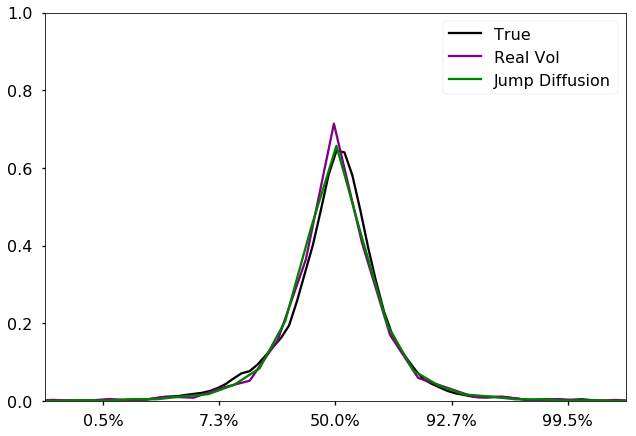

In [12]:
realized_density_fig, realized_density_ax = mpl.pyplot.subplots()
sns.kdeplot(data=stats.zscore(np.ravel(daily_rtn)), ax=realized_density_ax, color='black', label='True')
sns.kdeplot(stats.zscore(jump_diffusion_forecasts.dropna().values.ravel()), ax=realized_density_ax,
           color='purple', label='Real Vol')
sns.kdeplot(stats.zscore(diffusion_forecasts.dropna().values.ravel()), ax=realized_density_ax, color='green',
           label='Jump Diffusion')

realized_density_ax.legend()
realized_density_ax.set_xlabel("")
realized_density_ax.set_xlim([-5, 5])
realized_density_ax.set_ylim([0, 1])
realized_density_ax.set_xticklabels(["{:.1f}%".format(100 * lj.lapgaussconv.cdf(val)) 
                                     for val in realized_density_ax.get_xticks()])
realized_density_fig.savefig('../doc/figures/realized_density_comparison.tmp.pdf', bbox_inches='tight')

In [13]:
for data in [daily_rtn.dropna(), jump_diffusion_forecasts, diffusion_forecasts]:
    data_summary = stats.describe(data.values.ravel())
    print("Variance is {}.".format(data_summary.variance))
    print("Skewness is {}.".format(data_summary.skewness))
    print("Kurtosis is {}.\n".format(3 + data_summary.kurtosis))

Variance is 8.69752501745977e-05.
Skewness is -0.31221213201706327.
Kurtosis is 13.066157486276417.

Variance is 8.845697386643856e-05.
Skewness is 0.052389418706007135.
Kurtosis is 26.652623471337403.

Variance is 8.391866208781275e-05.
Skewness is -0.035542902795617975.
Kurtosis is 25.649740334286353.



## Compute The Pits

In [15]:
jump_diffusion_real_pit = lj.probability_integral_transform(jump_diffusion_forecasts, daily_rtn.dropna())
diffusion_real_pit = lj.probability_integral_transform(diffusion_forecasts, daily_rtn.dropna())

## Probability Integral Transforms

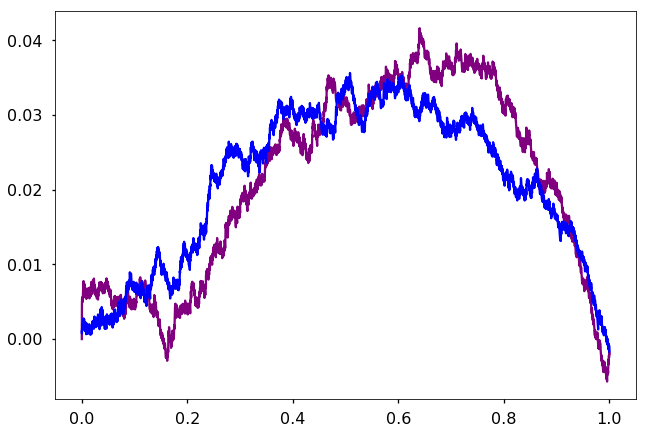

In [16]:
ar_xdata = np.linspace(0, 1, jump_diffusion_real_pit.shape[0])
abs_comp_fig, abs_comp_ax = mpl.pyplot.subplots()
abs_comp_ax.plot(ar_xdata, np.sort(jump_diffusion_real_pit.values.ravel()) - ar_xdata, color='purple')
abs_comp_ax.plot(ar_xdata, np.sort(diffusion_real_pit.values.ravel()) - ar_xdata, color='blue')

In [17]:
(np.mean(np.abs(np.sort(jump_diffusion_real_pit.values.ravel()) - ar_xdata)**2)
 / np.mean(np.abs(np.sort(diffusion_real_pit.values.ravel()) - ar_xdata))**2)

1.4138833268554116

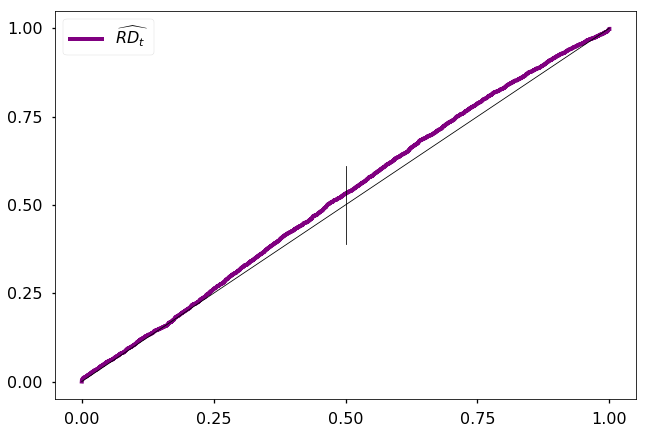

In [27]:
ar_forecast_qq_fig, ar_forecast_qq_ax = mpl.pyplot.subplots()
linewidth = ar_forecast_qq_ax.spines['left'].get_linewidth()
ar_xdata = np.linspace(0, 1, jump_diffusion_real_pit.shape[0])

ar_forecast_qq_ax.plot(ar_xdata, np.ravel(jump_diffusion_real_pit.sort_values(
    by='PIT')), c='purple', linewidth=4, label=r"$\widehat{RD_t}$")
# ar_forecast_qq_ax.plot(ar_xdata, np.ravel(diffusion_real_pit.sort_values(
#     by='PIT')), c='blue', linewidth=4, label=r"$\widehat{RD_t}$")
ar_forecast_qq_ax.plot(ar_xdata, ar_xdata, color='black', linewidth=linewidth)
ar_forecast_qq_ax.axvline(.5, color='black', ymin=0.4, ymax=0.6, linewidth=linewidth)
ar_forecast_qq_ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, .25, .5, .75, 1]))
ar_forecast_qq_ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([0, .25, .5, .75, 1]))
leg = ar_forecast_qq_ax.legend()


if presentation:
    filename = '../doc/figures/jump_diff_realized_density_qq.tmp.pdf'
    leg.get_texts()[0].set_color('purple')
    # leg.get_texts()[1].set_color('blue')
else:
    filename = '../doc/figures/jump_diff_realized_density_qq_paper.tmp.pdf'

ar_forecast_qq_fig.savefig(filename, frameon=False, transparent=True, bbox_inches='tight', pad_inches=0)

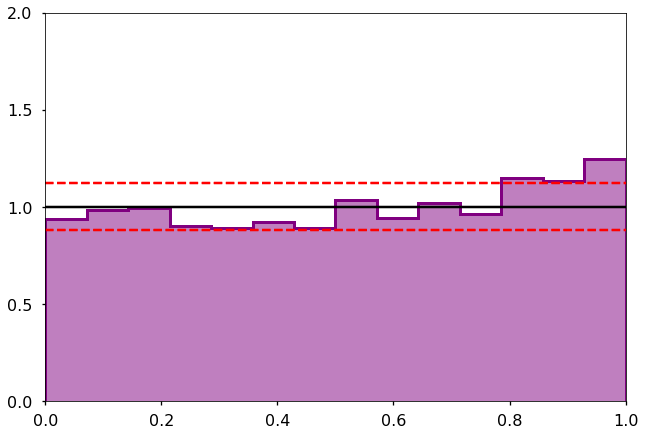

In [19]:
real_pit_fig, real_pit_ax = mpl.pyplot.subplots()

lj.pit_plot(jump_diffusion_real_pit, ax=real_pit_ax, hist_kws={"alpha": 1, "color": "purple",
                                                              "histtype":'step', 'linewidth':3})
lj.pit_plot(jump_diffusion_real_pit, ax=real_pit_ax, hist_kws={"alpha": .5, "color": "purple",
                                                              "histtype":'bar'})
# lj.pit_plot(diffusion_real_pit, ax=real_pit_ax, hist_kws={ 'histtype':'step', "linewidth" : 3,
#                                                           "alpha": 1, "color": "blue"})
if presentation:
    filename = '../doc/figures/jump_diff_realized_density_pit.tmp.pdf'
else:
    filename = '../doc/figures/jump_diff_realized_density_pit_paper.tmp.pdf'
real_pit_fig.savefig(filename, frameon=False, transparent=True, bbox_inches='tight', pad_inches=0)

In [20]:
(np.mean(np.abs(np.ravel(diffusion_real_pit.sort_values(by='PIT')) - ar_xdata)) /
        np.mean(np.abs(np.ravel(jump_diffusion_real_pit.sort_values(by='PIT')) - ar_xdata)))**(-1)

1.023155025475148

In [21]:
diffusion_real_pit['PIT'].autocorr()

-0.04492011187560543

In [22]:
jump_diffusion_real_pit['PIT'].autocorr()

-0.0392526261161928

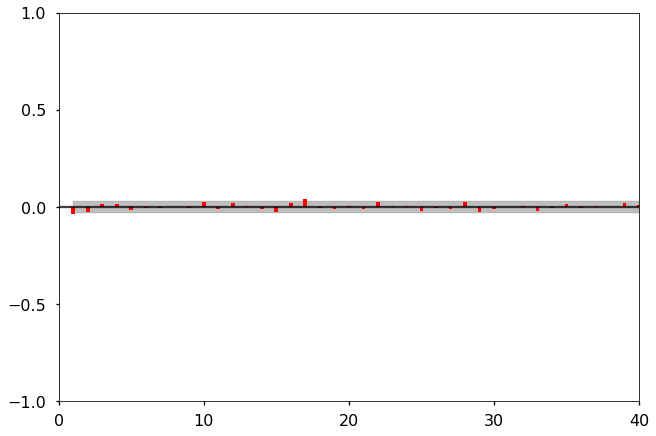

In [24]:
prop_autocorr_fig, prop_autocorr_ax = mpl.pyplot.subplots()
lj.pit_acf_plot(jump_diffusion_real_pit.PIT, origin_opts=True, nlags=41, ax=prop_autocorr_ax)

prop_autocorr_ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0, 10, 20, 30, 40]))
prop_autocorr_ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4))

if presentation:
    filename = '../doc/figures/realized_density_jump_diffusion_pit_acf.tmp.pdf'
else:
    filename = '../doc/figures/realized_density_jump_diffusion_pit_acf_paper.tmp.pdf'

prop_autocorr_fig.savefig(filename, frameon=False, 
                          transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
real_dens_fig, jump_diffusion_ax = mpl.pyplot.subplots()
labels = ['Median', '99.9%', '99%', '95%', '75%', '50%', '25%']
jump_diffusion_ax.plot(daily_rtn.dropna(), color='purple', label="$r_t$", zorder=10)
lj.fan_plot(ax=jump_diffusion_ax, data=jump_diffusion_forecasts, percentiles=percentiles, 
             labels=labels, cm=mpl.cm.get_cmap('gist_rainbow'), alpha=1)
jump_diffusion_ax.set_ylim([-.15, .15])
jump_diffusion_ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=2))
jump_diffusion_ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
jump_diffusion_ax.legend(ncol=2, loc='center left', bbox_to_anchor=(1,.4))
real_dens_fig.savefig('../doc/figures/realized_density.tmp.pdf', bbox_tight=True, transparent=True,
                         pad_inches=0)

## Plotting the relationship between "Uncertainty" and "Return"

In [ ]:
jump_proportion = pd.DataFrame(discrete_vol['jumps'] / (discrete_vol['diffusion'] + discrete_vol['jumps'])).rename(
    columns={0:'jump_prop'})

In [ ]:
jump_prop_and_rtn = pd.concat([jump_proportion, daily_rtn, discrete_vol['quad'], vix], axis=1).dropna()

In [ ]:
jump_prop_and_rtn.skew()

In [ ]:
jump_prop_and_rtn.corr()

In [ ]:
print(jump_prop_and_rtn.query('jump_prop > jump_prop.mean()').kurtosis() + 3)
print("\n The below average kurtosis is \n")
print(jump_prop_and_rtn.query('jump_prop < jump_prop.mean()').kurtosis() + 3)

In [ ]:
print('The mean on days with lots of jumps is {:0.6f}'.format(252 * jump_prop_and_rtn.query('jump_prop > jump_prop.mean()').loc[:, 'daily_rtn'].mean()))
print('The mean on days with only a few jumps is {:0.6f}'.format(252 * jump_prop_and_rtn.query('jump_prop < jump_prop.mean()').loc[:, 'daily_rtn'].mean()))
print('The overall mean is {:0.6f}'.format(jump_prop_and_rtn.loc[:, 'daily_rtn'].mean()))



In [ ]:
print('The variance on days with above average jumps is {:0.4e}'.format(
    252 * jump_prop_and_rtn.query('jump_prop > jump_prop.mean()').loc[:, 'quad'].mean()))
print('The variance on days with below average jumps is {:0.4e}'.format(
    252 * jump_prop_and_rtn.query('jump_prop < jump_prop.mean()').loc[:, 'quad'].mean()))
print('The overall variance is {:0.4e}'.format(252 * jump_prop_and_rtn.loc[:, 'quad'].mean()))


In [ ]:
print('The standard deviation on days with above average jumps is {:0.6f}'.format(
      252**.5 * jump_prop_and_rtn.query('jump_prop > jump_prop.mean()').loc[:, 'quad'].mean()**.5))
print('The standard deviation on days with below average jumps is {:0.6f}'.format(
       252**.5 * jump_prop_and_rtn.query('jump_prop < jump_prop.mean()').loc[:, 'quad'].mean()**.5))
print('The overall  standard deviation is {:0.6f}'.format(252**.5 * jump_prop_and_rtn.loc[:, 'quad'].mean()**.5))


In [ ]:
jump_prop_portfolio = np.sqrt(252) * (jump_prop_and_rtn.query('jump_prop > jump_prop.mean()').loc[:, 'daily_rtn'].mean()
     / np.sqrt(jump_prop_and_rtn.query('jump_prop > jump_prop.mean()').loc[:, 'quad'].mean()))
non_jump_prop_portfolio = np.sqrt(252) * (jump_prop_and_rtn.query('jump_prop < jump_prop.mean()').loc[:, 'daily_rtn'].mean()
     / np.sqrt(jump_prop_and_rtn.query('jump_prop < jump_prop.mean()').loc[:, 'quad'].mean()))
total_portfolio = np.sqrt(252) * (jump_prop_and_rtn.loc[:, 'daily_rtn'].mean()
     / np.sqrt(jump_prop_and_rtn.loc[:, 'quad'].mean()))

print("The jump proportion sharpe ratio is {:0.6f}".format(jump_prop_portfolio))
print("The low jump proportion sharpe ratio is {:0.6f}".format(non_jump_prop_portfolio))
print("The overall sharpe ratio is {:0.6f}".format(total_portfolio))
print("The ratio of sharpe ratios is {:0.6f}".format(jump_prop_portfolio / total_portfolio))

In [ ]:
sm.OLS.from_formula('daily_rtn ~ np.log(jump_prop) + np.log(vix)',
                    data=jump_prop_and_rtn.dropna()).fit().get_robustcov_results().summary()

In [ ]:
uncertainty_fig, uncertainty_ax = mpl.pyplot.subplots()
jump_prop_and_rtn.transform(stats.zscore).plot(ax=uncertainty_ax)    
uncertainty_ax.set_xlabel("")

In [ ]:
sns.distplot(jump_prop_and_rtn['jump_prop'].apply(np.log).dropna(), rug=True, fit=stats.norm)

In [ ]:
jump_prop_and_rtn['jump_prop'].apply(np.log).autocorr()

## Testing to see if we can reject the uniformity of the probability integral transforms. 

In [ ]:
stats.kstest(jump_diffusion_real_pit.values.ravel(), 'uniform')

In [ ]:
stats.kstest(diffusion_real_pit.values.ravel(), 'uniform')